<a href="https://colab.research.google.com/github/luijansuarez/ABC-XYZ-Analysis/blob/main/Case_5_ABCXYZ_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install pdfplumber

In [ ]:
import zipfile
import os
import pdfplumber
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib as Path

# Import the data

In [ ]:

# Let's create paths so we can extract the PDFs
from pathlib import Path
# 1) Paths
zip_path = Path("orders.zip")
extract_dir = Path("tmp_orders")       # folder to extract into
extract_dir.mkdir(parents=True, exist_ok=True)
# 2) Extract
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

# 3) Verify: list PDFs (recursively, in case there are subfolders)
pdf_paths = list(extract_dir.rglob("*.pdf"))
print("Extracted PDFs:", len(pdf_paths))

# 4) Sanity check (optional but recommended)
expected = 20000
if len(pdf_paths) != expected:
    print("⚠️ WARNING: expected", expected, "PDFs but found", len(pdf_paths))
else:
    print("✅ File count matches expected:", expected)

# 5) Peek at a few filenames
for p in pdf_paths[:10]:
    print(p)

Extracted PDFs: 20000
✅ File count matches expected: 20000
tmp_orders/orders/order_3117.pdf
tmp_orders/orders/order_4085.pdf
tmp_orders/orders/order_1199.pdf
tmp_orders/orders/order_14144.pdf
tmp_orders/orders/order_14374.pdf
tmp_orders/orders/order_6259.pdf
tmp_orders/orders/order_2911.pdf
tmp_orders/orders/order_11910.pdf
tmp_orders/orders/order_3947.pdf
tmp_orders/orders/order_6951.pdf


In [ ]:
# Let's look into the info in this PDFs
sample_pdf = pdf_paths[0]  # This is just the first PDF it extracted
print("OPENING:", sample_pdf.name)
with pdfplumber.open(sample_pdf) as pdf:
    text = pdf.pages[0].extract_text()
    import re
    clean_text = re.sub(r"\s+", " ", text)
print(text)
,
sample1_pdf = pdf_paths[1]  # This is the second PDF it extracted
print("OPENING:", sample1_pdf.name)
with pdfplumber.open(sample1_pdf) as pdf:
    text = pdf.pages[0].extract_text()
    import re
    clean_text = re.sub(r"\s+", " ", text)
print(text)


OPENING: order_3117.pdf
Order Number: ORD-4116
Client: Young-Nunez
Dispatch date: 2024-12-11
SKU Qty Price Total
SKU-300KV 35 2.10 73.50
GRAND TOTAL: 73.50
OPENING: order_4085.pdf
Order Number: ORD-5084
Client: Ramirez, Phillips and Greer
Dispatch date: 2025-02-25
SKU Qty Price Total
SKU-093KH 8 7.23 57.84
GRAND TOTAL: 57.84


In [ ]:
# Function that will standardardize the header for all files.
def parse_header(text: str) -> dict:
    # collapse weird whitespace
    t = re.sub(r"\s+", " ", text).strip()

    order_no = re.search(r"Order\s+Number:\s*(ORD-\d+)", t)
    client   = re.search(r"Client:\s*(.+?)\s+Dispatch\s+date:", t)
    date     = re.search(r"Dispatch\s+date:\s*(\d{4}-\d{2}-\d{2})", t)

    return {
        "order_no": order_no.group(1) if order_no else None,
        "client": client.group(1).strip() if client else None,
        "dispatch_date": date.group(1) if date else None,
    }


In [ ]:
# Now we can test the previous function. It will print the text from the last sample it extracted.
hdr = parse_header(text)
print(hdr)

{'order_no': 'ORD-5084', 'client': 'Ramirez, Phillips and Greer', 'dispatch_date': '2025-02-25'}


In [ ]:
# Now we test the same function with a random selection of PDFs
import random

sample_paths = random.sample(pdf_paths, 20)

bad = []
for p in sample_paths:
    with pdfplumber.open(p) as pdf:
        txt = pdf.pages[0].extract_text() or ""
    hdr = parse_header(txt)
    if None in hdr.values():
        bad.append((p.name, hdr))

print("Bad headers:", len(bad))
for b in bad[:5]:
    print(b)


Bad headers: 0


In [ ]:
# I followed a similar logic as before. Using the regular expression "re" again we recognize SKU, Qty, Price, Total.
# When it reaches Grand Total it will stop
import re

def get_item_lines(text: str) -> list[str]:
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]

    start = None
    for i, ln in enumerate(lines):
        if "SKU Qty Price Total" in ln:
            start = i + 1
            break

    if start is None:
        return []

    items = []
    for ln in lines[start:]:
        if ln.upper().startswith("GRAND TOTAL"):
            break
        items.append(ln)
    return items


item_re = re.compile(r"^(SKU-\S+)\s+(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)$")

def parse_items(text: str) -> list[dict]:
    out = []
    for ln in get_item_lines(text):
        m = item_re.match(ln)
        if not m:
            out.append({"raw_line": ln, "sku": None, "qty": None, "price": None, "line_total": None})
            continue
        sku, qty, price, total = m.groups()
        out.append({
            "sku": sku,
            "qty": int(qty),
            "price": float(price),
            "line_total": float(total),
        })
    return out


In [ ]:
print(get_item_lines(text))
print(parse_items(text))


['SKU-093KH 8 7.23 57.84']
[{'sku': 'SKU-093KH', 'qty': 8, 'price': 7.23, 'line_total': 57.84}]


In [ ]:
# We're going to verify if when there's several SKUs it works correctly
multi = None
for p in pdf_paths[:2000]:  # scan first 2000 to keep it fast
    with pdfplumber.open(p) as pdf:
        txt = pdf.pages[0].extract_text() or ""
    lines = get_item_lines(txt)
    if len(lines) > 1:
        multi = (p, txt, lines)
        break

print("Found:", multi[0].name, "items:", len(multi[2]) if multi else None)
print("\n".join(multi[2][:10]) if multi else "No multi-item found in scan")

Found: order_1199.pdf items: 5
SKU-541DL 89 8.18 728.02
SKU-465LJ 76 39.41 2995.16
SKU-825LK 9 0.23 2.07
SKU-694CF 47 5.98 281.06
SKU-111GR 93 20.86 1939.98


In [ ]:
p, txt, lines = multi
print(parse_items(txt))


[{'sku': 'SKU-541DL', 'qty': 89, 'price': 8.18, 'line_total': 728.02}, {'sku': 'SKU-465LJ', 'qty': 76, 'price': 39.41, 'line_total': 2995.16}, {'sku': 'SKU-825LK', 'qty': 9, 'price': 0.23, 'line_total': 2.07}, {'sku': 'SKU-694CF', 'qty': 47, 'price': 5.98, 'line_total': 281.06}, {'sku': 'SKU-111GR', 'qty': 93, 'price': 20.86, 'line_total': 1939.98}]


In [ ]:
# This is the fuction to build each row per PDF.
# Just to verify the line totals we are going to compute qty*price.
# We'll compare with line total and determine if there's a difference.
def build_rows_for_pdf(pdf_path) -> list[dict]:
    with pdfplumber.open(pdf_path) as pdf:
        txt = pdf.pages[0].extract_text() or ""

    hdr = parse_header(txt)
    items = parse_items(txt)

    rows = []
    for it in items:
        computed_total = round(it["qty"] * it["price"], 2)
        diff = round(computed_total - it["line_total"], 2)

        row = {
            **hdr,
            "source_file": pdf_path.name,
            **it,
            "computed_total": computed_total,
            "diff_total": diff,
            "total_match": abs(diff) <= 0.01,  # tolerance for rounding
        }
        rows.append(row)

    return rows


In [ ]:
rows = build_rows_for_pdf(p)   # p is the Path you found
rows[:2]


[{'order_no': 'ORD-2198',
  'client': 'Walker, Gomez and Kim',
  'dispatch_date': '2024-10-09',
  'source_file': 'order_1199.pdf',
  'sku': 'SKU-541DL',
  'qty': 89,
  'price': 8.18,
  'line_total': 728.02,
  'computed_total': 728.02,
  'diff_total': 0.0,
  'total_match': True},
 {'order_no': 'ORD-2198',
  'client': 'Walker, Gomez and Kim',
  'dispatch_date': '2024-10-09',
  'source_file': 'order_1199.pdf',
  'sku': 'SKU-465LJ',
  'qty': 76,
  'price': 39.41,
  'line_total': 2995.16,
  'computed_total': 2995.16,
  'diff_total': 0.0,
  'total_match': True}]

In [ ]:
# Now we run all of the files.
all_rows = []
errors = []

for p in tqdm(pdf_paths, desc="Parsing PDFs"):
    try:
        rows = build_rows_for_pdf(p)
        # optional: treat empty as an error signal
        if not rows:
            errors.append({"source_file": p.name, "error": "No line items parsed"})
            continue
        all_rows.extend(rows)
    except Exception as e:
        errors.append({"source_file": p.name, "error": str(e)})

df_orders = pd.DataFrame(all_rows)
df_errors = pd.DataFrame(errors)

print("df_orders:", df_orders.shape)
print("df_errors:", df_errors.shape)

Parsing PDFs: 100%|██████████| 20000/20000 [04:08<00:00, 80.62it/s]


df_orders: (29894, 11)
df_errors: (0, 0)


In [ ]:
df_orders.head()

,order_no,client,dispatch_date,source_file,sku,qty,price,line_total,computed_total,diff_total,total_match
0,ORD-4116,Young-Nunez,2024-12-11,order_3117.pdf,SKU-300KV,35,2.10,73.50,73.50,0.0,True
1,ORD-5084,"Ramirez, Phillips and Greer",2025-02-25,order_4085.pdf,SKU-093KH,8,7.23,57.84,57.84,0.0,True
2,ORD-2198,"Walker, Gomez and Kim",2024-10-09,order_1199.pdf,SKU-541DL,89,8.18,728.02,728.02,0.0,True
3,ORD-2198,"Walker, Gomez and Kim",2024-10-09,order_1199.pdf,SKU-465LJ,76,39.41,2995.16,2995.16,0.0,True
4,ORD-2198,"Walker, Gomez and Kim",2024-10-09,order_1199.pdf,SKU-825LK,9,0.23,2.07,2.07,0.0,True


In [ ]:
# After parsing the PDFs let's ensure that the dates and numeric values are in numerical mode, either float or integer.
df_orders["dispatch_date"] = pd.to_datetime(df_orders["dispatch_date"], errors="coerce")
for col in ["qty","price","line_total","computed_total","diff_total"]:
    df_orders[col] = pd.to_numeric(df_orders[col], errors="coerce")


In [ ]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29894 entries, 0 to 29893
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_no        29894 non-null  object        
 1   client          29894 non-null  object        
 2   dispatch_date   29894 non-null  datetime64[ns]
 3   source_file     29894 non-null  object        
 4   sku             29894 non-null  object        
 5   qty             29894 non-null  int64         
 6   price           29894 non-null  float64       
 7   line_total      29894 non-null  float64       
 8   computed_total  29894 non-null  float64       
 9   diff_total      29894 non-null  float64       
 10  total_match     29894 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 2.3+ MB


In [ ]:
(~df_orders["total_match"]).sum()


np.int64(0)

In [ ]:
len(df_orders['sku'].unique())

500

## ABC Analysis

In [ ]:
df_ABC = pd.pivot_table(
    df_orders,
    index="sku",
    values="line_total",
    aggfunc="sum",
).sort_values("line_total", ascending=False).reset_index()


In [ ]:
df_ABC["share"] = df_ABC["line_total"] / df_ABC["line_total"].sum()

In [ ]:
df_ABC

,sku,line_total,share
0,SKU-346HT,235637.65,0.011918
1,SKU-447ST,212826.36,0.010764
2,SKU-091IA,192557.67,0.009739
3,SKU-794VJ,174512.13,0.008827
4,SKU-011PE,147363.02,0.007453
...,...,...,...
495,SKU-311LF,3580.91,0.000181
496,SKU-289NR,3559.33,0.000180
497,SKU-603HO,3549.36,0.000180
498,SKU-055II,3376.29,0.000171


In [ ]:
# Organize SKUs in ABC category.
# 1) cumulative share (make sure it's sorted desc already)
df_ABC["cum_share"] = df_ABC["share"].cumsum()

# 2) ABC class based on cum_share
df_ABC["ABC"] = "C"
df_ABC.loc[df_ABC["cum_share"] <= 0.95, "ABC"] = "B"
df_ABC.loc[df_ABC["cum_share"] <= 0.80, "ABC"] = "A"

df_ABC.head(10)


,sku,line_total,share,cum_share,ABC
0,SKU-346HT,235637.65,0.011918,0.011918,A
1,SKU-447ST,212826.36,0.010764,0.022683,A
2,SKU-091IA,192557.67,0.009739,0.032422,A
3,SKU-794VJ,174512.13,0.008827,0.041248,A
4,SKU-011PE,147363.02,0.007453,0.048702,A
5,SKU-134BR,145770.73,0.007373,0.056075,A
6,SKU-089GP,143243.67,0.007245,0.063320,A
7,SKU-164LX,134698.42,0.006813,0.070132,A
8,SKU-518KI,128851.85,0.006517,0.076650,A
9,SKU-497TJ,128437.87,0.006496,0.083146,A


In [ ]:
df_ABC

,sku,line_total,share,cum_share,ABC
0,SKU-346HT,235637.65,0.011918,0.011918,A
1,SKU-447ST,212826.36,0.010764,0.022683,A
2,SKU-091IA,192557.67,0.009739,0.032422,A
3,SKU-794VJ,174512.13,0.008827,0.041248,A
4,SKU-011PE,147363.02,0.007453,0.048702,A
...,...,...,...,...,...
495,SKU-311LF,3580.91,0.000181,0.999325,C
496,SKU-289NR,3559.33,0.000180,0.999505,C
497,SKU-603HO,3549.36,0.000180,0.999685,C
498,SKU-055II,3376.29,0.000171,0.999855,C


In [ ]:
df_ABC["ABC"].value_counts()

,count
ABC,
A,233
B,144
C,123


In [ ]:
df_ABC.groupby("ABC")["share"].sum()


,share
ABC,
A,0.799683
B,0.149751
C,0.050566


In [ ]:
df_ABC.loc[df_ABC["ABC"]=="A", "cum_share"].max()

0.799683081729127

## XYZ Analysis

In [ ]:
sorted(df_orders["dispatch_date"].dt.year.unique())

[np.int32(2023), np.int32(2024), np.int32(2025)]

In [ ]:
df_orders["dispatch_date"].dt.year.value_counts().sort_index()

,count
dispatch_date,
2023,691
2024,14923
2025,14280


In [ ]:
df_orders["month"] = df_orders["dispatch_date"].dt.to_period("M")

In [ ]:
df_orders.head()

,order_no,client,dispatch_date,source_file,sku,qty,price,line_total,computed_total,diff_total,total_match,month
0,ORD-4116,Young-Nunez,2024-12-11,order_3117.pdf,SKU-300KV,35,2.10,73.50,73.50,0.0,True,2024-12
1,ORD-5084,"Ramirez, Phillips and Greer",2025-02-25,order_4085.pdf,SKU-093KH,8,7.23,57.84,57.84,0.0,True,2025-02
2,ORD-2198,"Walker, Gomez and Kim",2024-10-09,order_1199.pdf,SKU-541DL,89,8.18,728.02,728.02,0.0,True,2024-10
3,ORD-2198,"Walker, Gomez and Kim",2024-10-09,order_1199.pdf,SKU-465LJ,76,39.41,2995.16,2995.16,0.0,True,2024-10
4,ORD-2198,"Walker, Gomez and Kim",2024-10-09,order_1199.pdf,SKU-825LK,9,0.23,2.07,2.07,0.0,True,2024-10


In [ ]:
df_monthly = (
    df_orders.groupby(["sku", "month"], as_index=False)["qty"]
    .sum()
)

In [ ]:
df_monthly.head()

,sku,month,qty
0,SKU-000GO,2023-12,172
1,SKU-000GO,2024-01,3
2,SKU-000GO,2024-02,59
3,SKU-000GO,2024-03,65
4,SKU-000GO,2024-04,56


In [ ]:
# Let's calculate de mean and standard deviation for the XYZ analysis.
df_XYZ = (
    df_monthly.groupby("sku")["qty"]
    .agg(mean_qty="mean", std_qty="std", months_active="count")
    .reset_index()
)

In [ ]:
# If there are missing values will use 0 so that calculations can work.
df_XYZ["std_qty"] = df_XYZ["std_qty"].fillna(0)  # 1-month SKUs => std NaN
df_XYZ["cv"] = df_XYZ["std_qty"] / df_XYZ["mean_qty"]

In [ ]:
df_XYZ.isna().sum()

,0
sku,0
mean_qty,0
std_qty,0
months_active,0
cv,0


In [ ]:
# In case there is not enough data let's create a category called "N"
df_XYZ["XYZ"] = "N"  # default: Not enough data

enough = df_XYZ["months_active"] >= 2

df_XYZ.loc[enough, "XYZ"] = "Z"
df_XYZ.loc[enough & (df_XYZ["cv"] <= 1.0), "XYZ"] = "Y"
df_XYZ.loc[enough & (df_XYZ["cv"] <= 0.5), "XYZ"] = "X"

In [ ]:
df_XYZ

,sku,mean_qty,std_qty,months_active,cv,XYZ
0,SKU-000GO,71.727273,55.553648,22,0.774512,Y
1,SKU-003XK,67.608696,50.989963,23,0.754192,Y
2,SKU-006RV,77.333333,56.404337,24,0.729366,Y
3,SKU-007CO,71.000000,73.859203,23,1.040270,Z
4,SKU-010HL,83.090909,86.311677,22,1.038762,Z
...,...,...,...,...,...,...
495,SKU-990MO,59.600000,35.983037,20,0.603742,Y
496,SKU-991KB,70.500000,47.584261,22,0.674954,Y
497,SKU-992HY,85.761905,52.208146,21,0.608757,Y
498,SKU-997YC,78.695652,73.660422,23,0.936016,Y


In [ ]:
df_XYZ["XYZ"].value_counts()

,count
XYZ,
Y,450
Z,48
X,2


In [ ]:
df_XYZ["cv"].describe()

,cv
count,500.000000
mean,0.827924
std,0.130495
min,0.457728
25%,0.734345
50%,0.823778
75%,0.912430
max,1.255841


## ABC-XYZ Analysis

In [ ]:
# We'll merge ABC and XYZ analyses using the SKU as index.
df_class = df_ABC[["sku", "line_total", "share", "cum_share", "ABC"]].merge(
    df_XYZ[["sku", "cv", "XYZ", "months_active"]],
    on="sku",
    how="left"
)

In [ ]:
# Unite both analyses in a new column.
df_class["ABC_XYZ"] = df_class["ABC"] + df_class["XYZ"]

In [ ]:
df_class.head()

,sku,line_total,share,cum_share,ABC,cv,XYZ,months_active,ABC_XYZ
0,SKU-346HT,235637.65,0.011918,0.011918,A,0.792012,Y,25,AY
1,SKU-447ST,212826.36,0.010764,0.022683,A,0.752069,Y,23,AY
2,SKU-091IA,192557.67,0.009739,0.032422,A,1.031661,Z,24,AZ
3,SKU-794VJ,174512.13,0.008827,0.041248,A,0.704281,Y,24,AY
4,SKU-011PE,147363.02,0.007453,0.048702,A,0.687925,Y,20,AY


In [ ]:
df_class["ABC_XYZ"].value_counts()

,count
ABC_XYZ,
AY,213
BY,128
CY,109
AZ,19
BZ,15
CZ,14
AX,1
BX,1


In [ ]:
df_unicorn=df_class[df_class["ABC_XYZ"] == "AX"]
df_bone=df_class[df_class["ABC_XYZ"] == "CZ"]

In [ ]:
df_unicorn_bones=pd.concat([df_unicorn,df_bone]).reset_index(drop=True)

In [ ]:
df_unicorn_bones

,sku,line_total,share,cum_share,ABC,cv,XYZ,months_active,ABC_XYZ
0,SKU-575TZ,65489.52,0.003312,0.481298,A,0.491210,X,23,AX
1,SKU-071PX,11275.10,0.000570,0.965500,C,1.015330,Z,22,CZ
2,SKU-078RW,10881.22,0.000550,0.968302,C,1.092045,Z,22,CZ
3,SKU-590FU,10403.71,0.000526,0.971522,C,1.051790,Z,22,CZ
4,SKU-843RO,9880.62,0.000500,0.974589,C,1.064406,Z,22,CZ
5,SKU-290BM,9077.15,0.000459,0.977986,C,1.008273,Z,20,CZ
6,SKU-247IM,7150.94,0.000362,0.987136,C,1.075727,Z,22,CZ
7,SKU-889XJ,7091.39,0.000359,0.987854,C,1.029573,Z,22,CZ
8,SKU-699JD,6039.92,0.000305,0.991507,C,1.191051,Z,23,CZ
9,SKU-366WY,5510.03,0.000279,0.992363,C,1.009286,Z,23,CZ


In [ ]:
df_bone

,sku,line_total,share,cum_share,ABC,cv,XYZ,months_active,ABC_XYZ
402,SKU-071PX,11275.10,0.000570,0.965500,C,1.015330,Z,22,CZ
407,SKU-078RW,10881.22,0.000550,0.968302,C,1.092045,Z,22,CZ
413,SKU-590FU,10403.71,0.000526,0.971522,C,1.051790,Z,22,CZ
419,SKU-843RO,9880.62,0.000500,0.974589,C,1.064406,Z,22,CZ
426,SKU-290BM,9077.15,0.000459,0.977986,C,1.008273,Z,20,CZ
449,SKU-247IM,7150.94,0.000362,0.987136,C,1.075727,Z,22,CZ
451,SKU-889XJ,7091.39,0.000359,0.987854,C,1.029573,Z,22,CZ
462,SKU-699JD,6039.92,0.000305,0.991507,C,1.191051,Z,23,CZ
465,SKU-366WY,5510.03,0.000279,0.992363,C,1.009286,Z,23,CZ
471,SKU-773BK,5225.42,0.000264,0.993976,C,1.026051,Z,21,CZ


In [ ]:
df_unicorn

,sku,line_total,share,cum_share,ABC,cv,XYZ,months_active,ABC_XYZ
96,SKU-575TZ,65489.52,0.003312,0.481298,A,0.49121,X,23,AX


## Data Visualizations

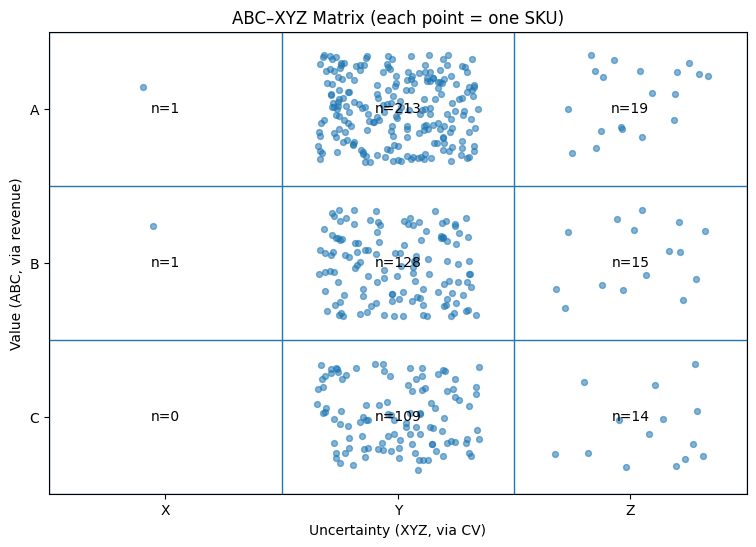

In [ ]:
# Let's try to create a grid 3x3 visualization of the classes.
import numpy as np
import matplotlib.pyplot as plt

# df_class must contain columns: 'ABC', 'XYZ' (and ideally 'ABC_XYZ' or 'line_total')
# Ensure only X/Y/Z and A/B/C are present
plot_df = df_class[df_class["ABC"].isin(list("ABC")) & df_class["XYZ"].isin(list("XYZ"))].copy()

x_map = {"X": 0, "Y": 1, "Z": 2}
y_map = {"C": 0, "B": 1, "A": 2}

plot_df["x"] = plot_df["XYZ"].map(x_map)
plot_df["y"] = plot_df["ABC"].map(y_map)

# jitter inside each cell
rng = np.random.default_rng(42)
plot_df["xj"] = plot_df["x"] + rng.uniform(-0.35, 0.35, size=len(plot_df))
plot_df["yj"] = plot_df["y"] + rng.uniform(-0.35, 0.35, size=len(plot_df))

plt.figure(figsize=(9, 6))
plt.scatter(plot_df["xj"], plot_df["yj"], alpha=0.55, s=18)

# draw grid lines
for v in [-0.5, 0.5, 1.5, 2.5]:
    plt.axvline(v, linewidth=1)
    plt.axhline(v, linewidth=1)

plt.xticks([0,1,2], ["X", "Y", "Z"])
plt.yticks([0,1,2], ["C", "B", "A"])

plt.xlabel("Uncertainty (XYZ, via CV)")
plt.ylabel("Value (ABC, via revenue)")
plt.title("ABC–XYZ Matrix (each point = one SKU)")

# annotate counts in each cell
counts = plot_df.groupby(["ABC","XYZ"]).size()
for abc in ["A","B","C"]:
    for xyz in ["X","Y","Z"]:
        n = int(counts.get((abc, xyz), 0))
        plt.text(x_map[xyz], y_map[abc], f"n={n}", ha="center", va="center")

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 2.5)
plt.show()


<Axes: xlabel='ABC_XYZ'>

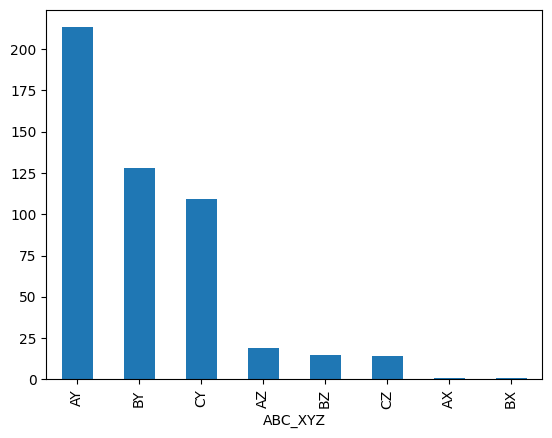

In [ ]:
# Bar chart of the SKU per class organize by descending order.
bucket_counts = df_class["ABC_XYZ"].value_counts().sort_values(ascending=False)
bucket_counts.plot(kind="bar")


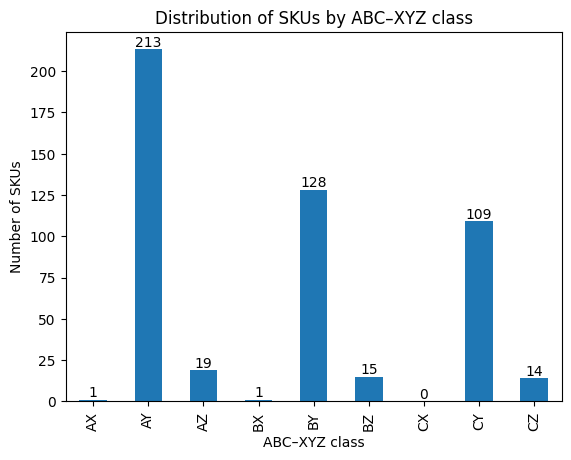

,count
ABC_XYZ,
AX,0.2
AY,42.6
AZ,3.8
BX,0.2
BY,25.6
BZ,3.0
CX,0.0
CY,21.8
CZ,2.8


In [ ]:
# Bar chart of the SKU per class organize by ABC-XYZ order.
import pandas as pd
import matplotlib.pyplot as plt

order = ["AX","AY","AZ","BX","BY","BZ","CX","CY","CZ"]

bucket_counts = df_class["ABC_XYZ"].value_counts().reindex(order, fill_value=0)

ax = bucket_counts.plot(kind="bar")
ax.set_xlabel("ABC–XYZ class")
ax.set_ylabel("Number of SKUs")
ax.set_title("Distribution of SKUs by ABC–XYZ class")

# optional: show counts on bars
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha="center", va="bottom"
    )

plt.show()
bucket_pct = (bucket_counts / bucket_counts.sum() * 100).round(1)
bucket_pct

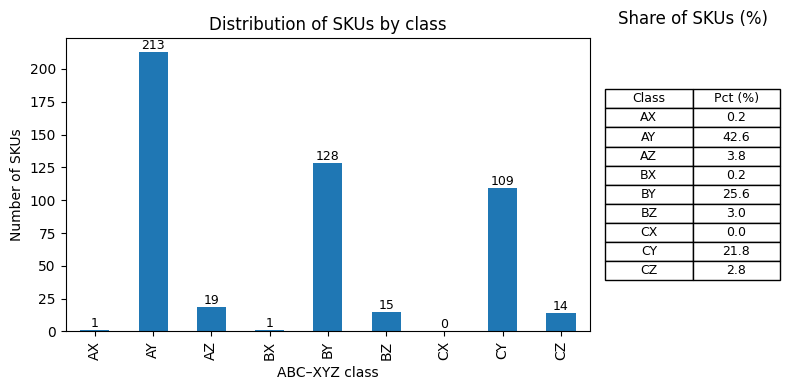

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

order = ["AX","AY","AZ","BX","BY","BZ","CX","CY","CZ"]

bucket_counts = df_class["ABC_XYZ"].value_counts().reindex(order, fill_value=0)
bucket_pct = (bucket_counts / bucket_counts.sum() * 100).round(1)

# Table data (no Count column)
tbl = pd.DataFrame({
    "Class": bucket_counts.index,
    "Pct (%)": bucket_pct.values
})

fig, (ax_bar, ax_tbl) = plt.subplots(
    1, 2, figsize=(8, 4),
    gridspec_kw={"width_ratios": [3, 1]}
)

# Bar chart
bucket_counts.plot(kind="bar", ax=ax_bar)
ax_bar.set_xlabel("ABC–XYZ class")
ax_bar.set_ylabel("Number of SKUs")
ax_bar.set_title("Distribution of SKUs by class")

# Optional bar labels
for p in ax_bar.patches:
    ax_bar.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha="center", va="bottom", fontsize=9
    )

# Table
ax_tbl.axis("off")
ax_tbl.set_title("Share of SKUs (%)", pad=10)

table = ax_tbl.table(
    cellText=tbl[["Class","Pct (%)"]].values,
    colLabels=["Class","Pct (%)"],
    cellLoc="center",
    colLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.2)

plt.tight_layout()
plt.show()
fig.savefig("abc_xyz_distribution.png", dpi=200, bbox_inches="tight")


In [ ]:
summary = (
    df_class.groupby("ABC_XYZ")
    .agg(
        sku_count=("sku","count"),
        revenue=("line_total","sum")
    )
)
summary["revenue_share"] = summary["revenue"] / summary["revenue"].sum()
summary = summary.sort_values("revenue", ascending=False).reset_index()
summary

,ABC_XYZ,sku_count,revenue,revenue_share
0,AY,213,14332336.37,0.724906
1,BY,128,2627513.20,0.132895
2,AZ,19,1412942.65,0.071464
3,CY,109,899684.80,0.045505
4,BZ,15,305888.57,0.015471
5,CZ,14,100073.62,0.005062
6,AX,1,65489.52,0.003312
7,BX,1,27364.30,0.001384


In [ ]:
total_skus = df_class["sku"].nunique()
ax_n = len(df_unicorn)
cz_n = len(df_bone)
cz_pct = cz_n / total_skus * 100


## Report Creation

In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00


In [ ]:
from reportlab.lib.pagesizes import LETTER
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, ListFlowable, ListItem, Image
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

In [ ]:
df_bone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 402 to 492
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sku            14 non-null     object 
 1   line_total     14 non-null     float64
 2   share          14 non-null     float64
 3   cum_share      14 non-null     float64
 4   ABC            14 non-null     object 
 5   cv             14 non-null     float64
 6   XYZ            14 non-null     object 
 7   months_active  14 non-null     int64  
 8   ABC_XYZ        14 non-null     object 
dtypes: float64(4), int64(1), object(4)
memory usage: 1.1+ KB


In [ ]:
# PDF report creation
from datetime import datetime

def df_to_table_data(df: pd.DataFrame, cols: list[str], max_rows: int = 30):
    """Convert df to a list-of-lists for ReportLab Table, limiting rows for readability."""
    df_small = df.loc[:, cols].head(max_rows).copy()
    # Convert everything to strings for clean rendering
    data = [cols] + df_small.astype(str).values.tolist()
    return data

def make_pdf_report(df_class: pd.DataFrame,
                    df_unicorn: pd.DataFrame,
                    df_bone: pd.DataFrame,
                    out_path: str = "ABC_XYZ_Report.pdf"):

    styles = getSampleStyleSheet()
    doc = SimpleDocTemplate(out_path, pagesize=LETTER)
    story = []

    # ---- Title ----
    story.append(Paragraph("ABC–XYZ Inventory Classification Report", styles["Title"]))
    story.append(Spacer(1, 8))
    story.append(Paragraph(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", styles["Normal"]))
    story.append(Spacer(1, 14))

    # ---- Summary ----
    story.append(Paragraph(
    "Following an exhaustive analysis of the dispatch receipt PDFs, we classified each SKU using a combined ABC–XYZ methodology:",
    styles["Normal"]
    ))

    story.append(Paragraph("<b>XYZ methodology</b>", styles["Heading3"]))
    story.append(Spacer(1, 6))

    top = [
        Paragraph("ABC (value contribution): based on cumulative revenue share (A ≈ top 80%, B ≈ next 15%, C ≈ last 5%).", styles["Normal"]),
        Paragraph("XYZ (demand variability): based on monthly demand coefficient of variation (CV = σ/μ).", styles["Normal"]),
    ]

    story.append(ListFlowable([ListItem(x) for x in top], bulletType="bullet", leftIndent=18))
    story.append(Spacer(1, 6))

    xyz_items = [
        Paragraph("X: CV ≤ 0.5 (stable)", styles["Normal"]),
        Paragraph("Y: 0.5 < CV ≤ 1.0 (moderate variability)", styles["Normal"]),
        Paragraph("Z: CV > 1.0 (erratic)", styles["Normal"]),
    ]
    story.append(ListFlowable([ListItem(x) for x in xyz_items], bulletType="bullet", leftIndent=28))

    total_skus = df_class["sku"].nunique()
    total_rev = df_class["line_total"].sum() if "line_total" in df_class.columns else None

    # Counts by class (if available)
    class_counts = df_class["ABC_XYZ"].value_counts() if "ABC_XYZ" in df_class.columns else pd.Series(dtype=int)

    summary_lines = [
        f"Total SKUs: {total_skus}",
    ]
    if total_rev is not None:
        summary_lines.append(f"Total Revenue: {total_rev:,.2f}$")

    story.append(Paragraph("<b>Summary</b>", styles["Heading2"]))
    for line in summary_lines:
        story.append(Paragraph(line, styles["Normal"]))
    story.append(Spacer(1, 14))

    # ---- Helper for styled tables ----
    def add_table_section(title: str, df: pd.DataFrame, cols: list[str], sort_col: str | None = None):
        story.append(Paragraph(f"<b>{title}</b>", styles["Heading2"]))
        story.append(Spacer(1, 6))

        if df is None or df.empty:
            story.append(Paragraph("No items found in this category.", styles["Normal"]))
            story.append(Spacer(1, 14))
            return

        dfx = df.copy()
        if sort_col and sort_col in dfx.columns:
            dfx = dfx.sort_values(sort_col, ascending=False)

        data = df_to_table_data(dfx, cols=cols, max_rows=30)

        table = Table(data, hAlign="LEFT")
        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.black),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("FONTSIZE", (0, 0), (-1, -1), 9),
            ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
            ("ROWBACKGROUNDS", (0, 1), (-1, -1), [colors.whitesmoke, colors.white]),
            ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
            ("LEFTPADDING", (0, 0), (-1, -1), 4),
            ("RIGHTPADDING", (0, 0), (-1, -1), 4),
            ("TOPPADDING", (0, 0), (-1, -1), 3),
            ("BOTTOMPADDING", (0, 0), (-1, -1), 3),
        ]))

        story.append(table)
        story.append(Spacer(1, 14))

    # ---- Choose columns to show ----
    # Adjust these column names to match your df_class
    unicorn_cols = ["sku", "line_total", "share", "cv", "ABC_XYZ"]
    bones_cols   = ["sku", "line_total", "share", "cv", "ABC_XYZ"]

    # If any columns are missing, drop them safely:
    unicorn_cols = [c for c in unicorn_cols if c in df_unicorn.columns]
    bones_cols   = [c for c in bones_cols if c in df_bone.columns]

    add_table_section("Unicorn SKUs (AX)", df_unicorn, cols=unicorn_cols, sort_col="line_total")
    story.append(Paragraph( "Unicorn SKUs (AX): high-value and stable-demand items that merit the highest service levels and tight replenishment control.",styles["Normal"]))
    add_table_section("Bone SKUs (CZ)", df_bone, cols=bones_cols, sort_col="line_total")
    story.append(Paragraph( "Bone SKUs (CZ): low-value and erratic-demand items that may be candidates for rationalization, make-to-order treatment, or reduced stocking.",styles["Normal"]))
    story.append(Paragraph("Portfolio Distribution",styles["Heading2"]))
    story.append(Paragraph("The chart below summarizes the distribution of all SKUs across the nine ABC–XYZ classes.",styles["Normal"]))
    story.append(Image("abc_xyz_distribution.png", width=450, height=250))
    story.append(Spacer(1, 12))

    doc.build(story)
    return out_path
def df_to_table_data(df: pd.DataFrame, cols: list[str], max_rows: int = 30):
    df_small = df.loc[:, cols].head(max_rows).copy()

    # Safe numeric formatting helpers
    def fmt_money(s):
        s = pd.to_numeric(s, errors="coerce")
        return s.map(lambda v: "" if pd.isna(v) else f"{v:,.2f}")

    def fmt_share(s):
        s = pd.to_numeric(s, errors="coerce")
        return s.map(lambda v: "" if pd.isna(v) else f"{v*100:.2f}%")

    def fmt_cv(s):
        s = pd.to_numeric(s, errors="coerce")
        return s.map(lambda v: "" if pd.isna(v) else f"{v:.3f}")

    # Apply formatting only if those columns exist
    if "line_total" in df_small.columns:
        df_small["line_total"] = fmt_money(df_small["line_total"])
    if "share" in df_small.columns:
        df_small["share"] = fmt_share(df_small["share"])
    if "cv" in df_small.columns:
        df_small["cv"] = fmt_cv(df_small["cv"])

    data = [cols] + df_small.astype(str).values.tolist()
    return data
pdf_path = make_pdf_report(df_class, df_unicorn, df_bone, out_path="ABC_XYZ_Report.pdf")
pdf_path


'ABC_XYZ_Report.pdf'